In [1]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree, toyplot

In [253]:
meta=pd.read_csv('metadata.csv')
meta

,name,strain,species
0,ERR027294,Microti,Microti
1,SRR3745458,Dassie,Dassie
2,ERR552526,Caprae,Caprae
3,ERR161048,BCG,BCG
4,SRR7983756,BCG-Danish,BCG
5,ERR766257,BCG-Pasteur,BCG
6,ERR766251,BCG-Japan,BCG
7,ERR766266,BCG-Russia,BCG
8,ERR766254,BCG-Moreau,BCG
9,39-MBovis,Bovis-Wicklow,Bovis


In [ ]:
reload(app)
args = {'threads':12,'outdir': 'results_mtb', 'labelsep':'_',
        'input':['data'],
         'species': 'MTB-H37Rv', #'Mbovis-AF212297',
         'overwrite':False,'unmapped':True,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [227]:
samples=W.fastq_table
samples=samples.merge(meta,left_on='sample',right_on='name')

In [212]:
treefile = 'results_mtb/tree.newick'
tre = toytree.tree(treefile)
#tre = tre.root('ref')
tre = tre.drop_tips('ref')
canvas,t,r=tre.draw(height=400,width=800)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="400.0px" viewBox="0 0 800.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2c46c0ff7e1d434cb6738662d86e84a3"> SRR3745458 59-6110 39-MBovis cat-003488 dog-1034 049-2005-NI TB19-007986 ERR400386 ERR766251 ERR766266 ERR766254 SRR7983756 ERR766257 ERR552526 ERR027294

In [221]:
mapdict=dict(zip(meta.name,meta.strain))

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


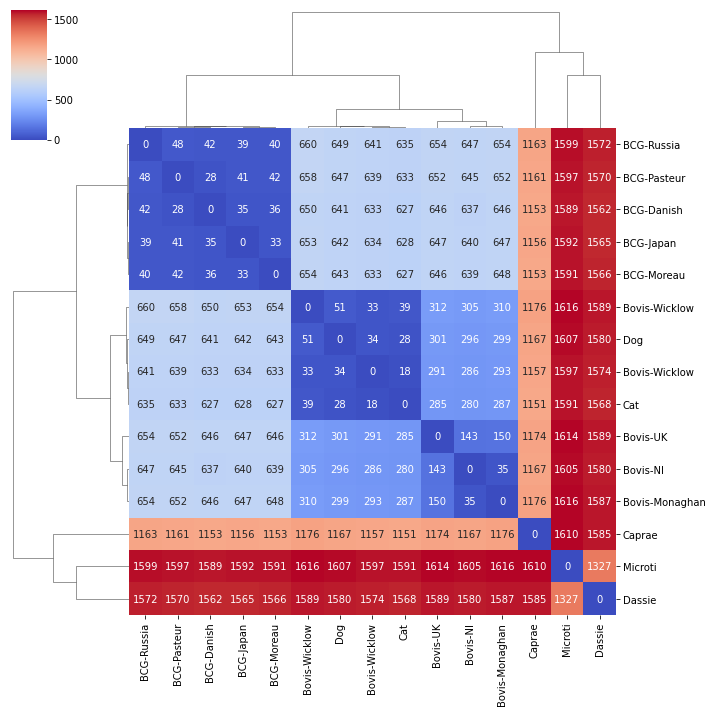

In [230]:
mat=pd.read_csv('results_mtb/snpdist.csv',index_col=0)
mat.index=mat.index.map(mapdict)
mat.columns=mat.columns.map(mapdict)
g=sns.clustermap(mat,annot=True,cmap='coolwarm',fmt='g')
#mat.style.background_gradient(cmap='coolwarm')

In [233]:
clnames = g.data2d.index

## rd analysis

In [290]:
from snipgenie import rdiff
rdiff.create_rd_index()
samples = pd.read_csv('results_mtb/samples.csv')
res = rdiff.run_samples(samples,'results/rd_aligned',threads=20)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('rd.csv')

bwa index RD.fa
049-2005-NI
39-MBovis
59-6110
ERR027294
ERR400386
ERR552526
ERR766251
ERR766254
ERR766257
ERR766266
SRR3745458
SRR7983756
TB19-007986
cat-003488
dog-1034


<AxesSubplot:ylabel='name'>

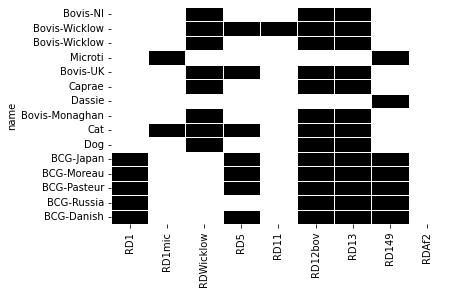

In [291]:
X=pd.read_csv('rd.csv',index_col=0)
X.index=X.index.map(mapdict)
x=X.iloc[:,:-1]
#cols=x.columns[(x.sum()<13) & (x.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD5','RD11','RD12bov','RD13','RD149','RDAf2']
sns.heatmap(x[cols],lw=1,ec='b',cbar=False,cmap='gray_r')

In [292]:
X=pd.read_csv('rd.csv',index_col=0)
final=meta.merge(X[cols],left_on='name',right_index=True)
final.to_csv('final.csv',index=False)

In [ ]:
spo = tools.get_spoligotypes(samples)

In [286]:
df = get_coverage('results_mtb/mapped/ERR766254.bam','NC_000962.3',4355500,4356000,app.mtb_genome)
#df

In [293]:
rec = list(SeqIO.parse(app.mtb_gb,format='gb'))[0]
rec.features = [f for f in rec.features if f.type!='gene']

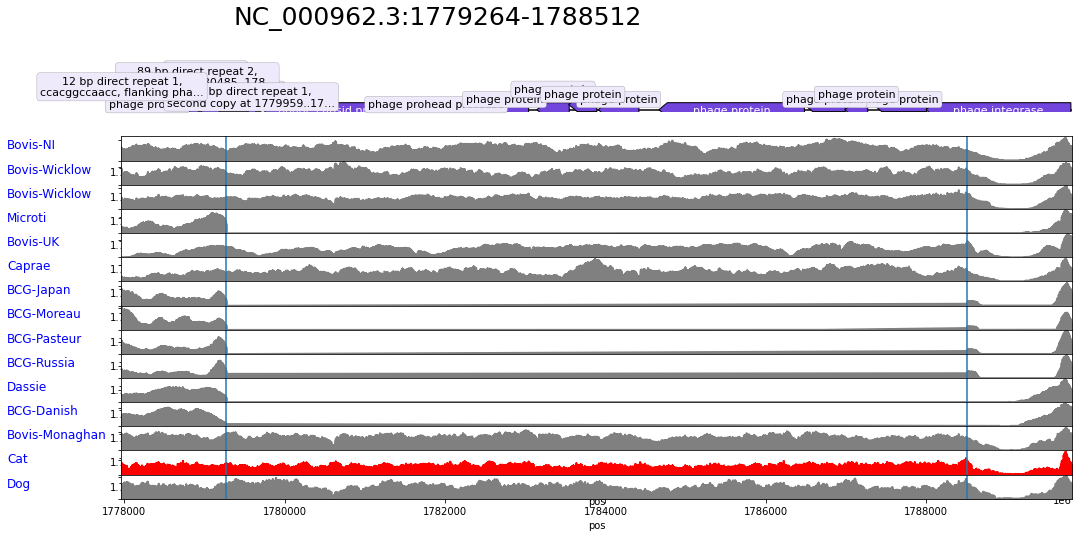

In [288]:
reload(rdiff)
samples['strain'] = samples['sample'].map(mapdict)
#rdiff.show_rd_coverage('NC_000962.3',4339000,4380000,app.mtb_genome,colors={'cat-003488':'red'},margin=1300)
rdiff.show_rd_coverage(samples,'NC_000962.3',1779264,1788512,app.mtb_genome,app.mtb_gb,colors={'cat-003488':'red'},labelcol='strain',margin=1300)

In [ ]:
rd = pd.read_csv('/home/farrell/gitprojects/snipgenie/snipgenie/data/RD.csv')
rd

In [ ]:
for i,r in rd[31:32].iterrows():
    show_rd_reads('NC_000962.3',r.Start,r.Stop,app.mtb_genome,title=r.RD_name,colors={'cat-003488':'red'},margin=1500)
    plt.show()

In [ ]:
#s=4352500;e=4359000
s=4339000;e=4365000
rs=np.random.randint(2,4e6)
for n,r in samples[1:4].iterrows():        
    bdf = get_coverage(r.bam_file,'NC_000962.3',rs,rs+5000,app.mtb_genome)    
    df = get_coverage(r.bam_file,'NC_000962.3',s,e,app.mtb_genome)
  
    df['x'] = df.coverage.diff().fillna(0).astype(int)
    #v = df.groupby('coverage').agg({'coverage':np.size})
    v = df.coverage.sum()/(e-s)
    print(v)    
    #v.plot()
    print (r.strain)
    print (bdf.coverage.mean(),df.coverage.mean(),df.x.mean())
    fig,ax = plt.subplots(2,1,figsize=(12,2))
    axs=ax.flat
    df.plot(x='pos',y='x',kind='line',legend=False,ax=axs[0])
    df.plot(x='pos',y='coverage',kind='line',lw=.3,legend=False,ax=axs[1])
    plt.show()
    

## assembly

In [ ]:
def spades(f1,f2,out,threads=12):
    cmd = 'spades --pe1-1 {f1} --pe1-2 {f2} --careful -t {t} -o {o}'.format(f1=f1,f2=f2,o=out,t=threads)    
    if not os.path.exists(out): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    return

path = 'assembly'
for i,r in samples.iterrows():
    name=r['sample']
    #if name in ['ERR027294','cat-003488']:                
    spades(r.filename1,r.filename2,os.path.join(path,r['sample']))   

In [185]:
#indels
v=tools.vcf_to_dataframe('results_mtb/indels.vcf.gz')
v['length']=v.end-v.start
#v.sort_values('length')
mat=pd.pivot_table(v,index='sample',columns='start',values='length').T
mat

sample,39-MBovis,59-6110,ERR027294,ERR552526,ERR766251,ERR766254,ERR766257,ERR766266,SRR3745458,SRR7983756,TB19-007986,cat-003488,dog-1034
start,,,,,,,,,,,,,
13227.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
24697.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0
28933.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
30979.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
30981.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383141.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4383143.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4385030.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


## detect missing regions by binned intervals

In [181]:
bam_file='results_mtb/mapped/cat-003488.bam'
s=4209000;e=4380000
df = get_coverage(bam_file,'NC_000962.3',s,e,app.mtb_genome)

In [133]:
bins = int((e-s)/1000)
print (bins)
pd.cut(df.set_index('pos').coverage,bins=bins)
intv = df.groupby(pd.cut(df["pos"], bins=bins )).sum()[['coverage']].reset_index()

171


In [182]:
#extract regions
intv[intv.coverage<=2]

def merge_intervals(df):
    df['block'] = (df.coverage.shift(1) != df.coverage).astype(int).cumsum()
    res = df.groupby(['block','coverage']).agg({'pos': np.min}).reset_index()
    return res
merge_intervals(intv)

,block,coverage,pos
0,1,163531,"(4208829.0, 4210000.0]"
1,2,163900,"(4210000.0, 4211000.0]"
2,3,156706,"(4211000.0, 4212000.0]"
3,4,152236,"(4212000.0, 4213000.0]"
4,5,168639,"(4213000.0, 4214000.0]"
...,...,...,...
153,154,175369,"(4375000.0, 4376000.0]"
154,155,159502,"(4376000.0, 4377000.0]"
155,156,156235,"(4377000.0, 4378000.0]"
156,157,132639,"(4378000.0, 4379000.0]"


<AxesSubplot:xlabel='pos'>

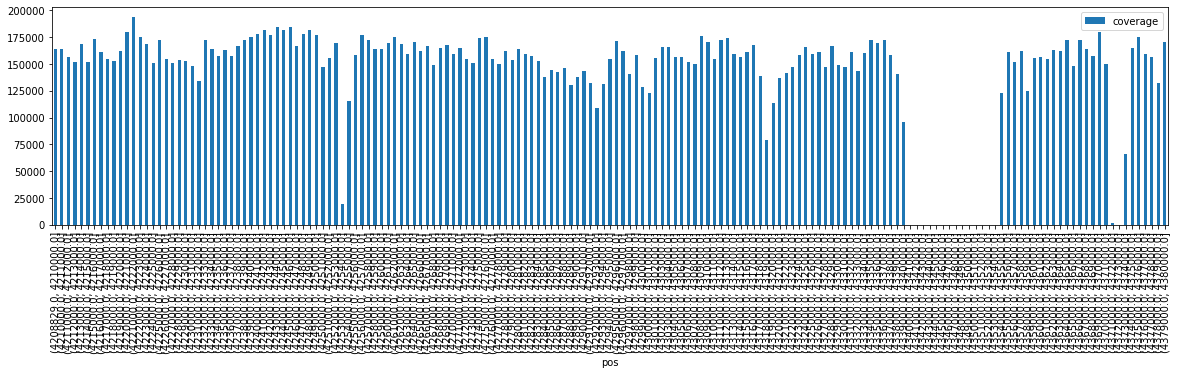

In [183]:
intervals.plot(x='pos',y='coverage',kind='bar',figsize=(20,4))

## use mtbdiff to detect large indels?


In [15]:
import mtbdiff 

In [ ]:
path = 'assembly'
names = mtbdiff.run_genomes(path, outpath='bovis_diff')

In [46]:
struct, snp =  mtbdiff.get_nucdiff_results('bovis_diff', names)
struct['RD'] = struct.apply(mtbdiff.get_region,1)
struct=struct[struct.length>10]
struct=struct.merge(meta,left_on='label',right_on='name')

In [48]:
struct[:5]

,ID,Name,color,del_len,descr,end,label,length,query_coord,query_dir,query_sequence,ref_repeated_region,source,start,insertion_length,RD,name,strain,species
0,SV_72,deletion,#0000EE,NaN,deletion_264754:266656,266656,ERR766251,1902,68619,NaN,NODE_8_length_139862_cov_44.219631,NaN,NucDiff_v2.0,264754,0,RD10,ERR766251,BCG-Japan,BCG
1,SV_271,inversion,#01DFD7,NaN,inversion_334634:335651,335651,ERR766251,1017,29-1045,NaN,NODE_92_length_1631_cov_12.706218,NaN,NucDiff_v2.0,334634,1016,-,ERR766251,BCG-Japan,BCG
2,SV_272,deletion,#0000EE,NaN,deletion_335651:337000,337000,ERR766251,1349,1045,NaN,NODE_92_length_1631_cov_12.706218,NaN,NucDiff_v2.0,335651,0,-,ERR766251,BCG-Japan,BCG
3,SV_268,collapsed_repeat,#0000EE,NaN,collapsed_repeat_335870:336379,336379,ERR766251,509,1826,NaN,NODE_89_length_2260_cov_33.373696,NaN,NucDiff_v2.0,335870,0,-,ERR766251,BCG-Japan,BCG
4,SV_267,deletion,#0000EE,NaN,deletion_336379:338633,338633,ERR766251,2254,1826,NaN,NODE_89_length_2260_cov_33.373696,NaN,NucDiff_v2.0,336379,0,-,ERR766251,BCG-Japan,BCG


In [47]:
wsamples=['cat-003488','39-Mbovis']
found=struct[(struct.Name=='deletion') & (struct.label.isin(wsamples))]
len(found)

53

In [ ]:
for i,r in found[30:40].iterrows():
    print (r.start,r.end)
    show_rd_reads('NC_000962.3',r.start,r.end,app.mtb_genome,title=r.descr,colors={'cat-003488':'red'},margin=1000)
    plt.show()

In [21]:
filt = struct#[struct.region!='PE/PPE']
rdmat = mtbdiff.RD_matrix(filt, columns=['label','strain'])
smat = mtbdiff.sites_matrix(filt, columns=['strain'], freq=2)
print (len(smat))
#smat.to_csv('sites_matrix.csv',index=False)
species = smat.T.index.get_level_values(0)
lut = dict(zip(species.unique(), "rbg"))
row_colors = species.map(lut)

115


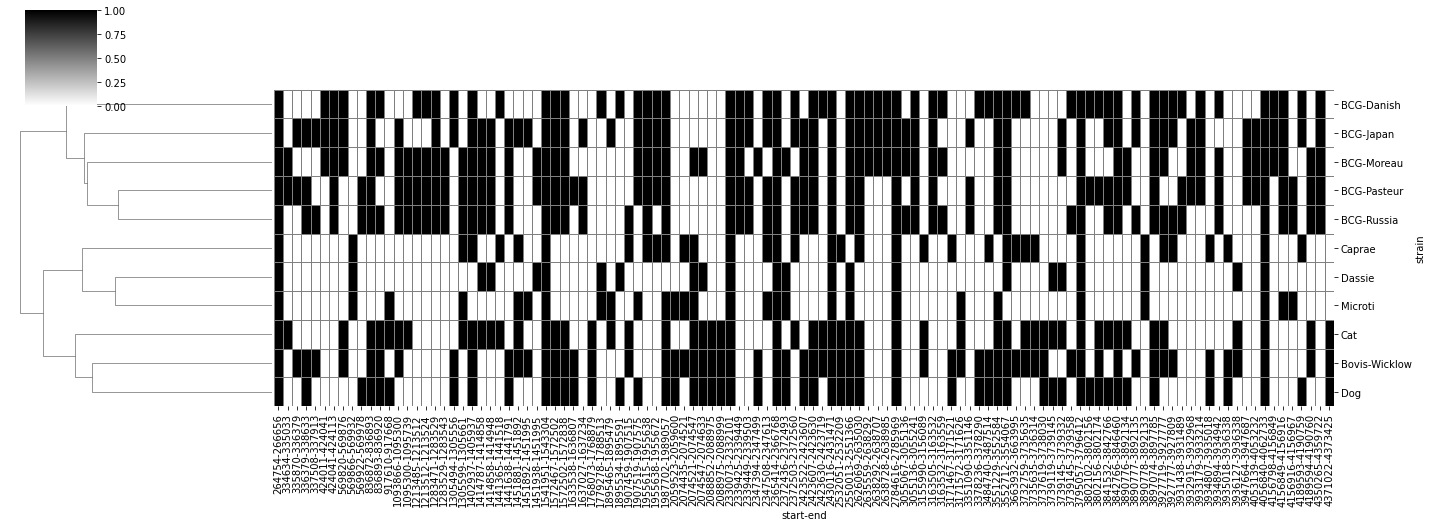

In [22]:
reload(mtbdiff.analysis)
X=smat.T
cm = mtbdiff.plot_RD(X, width=20,col_cluster=False)